In [68]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

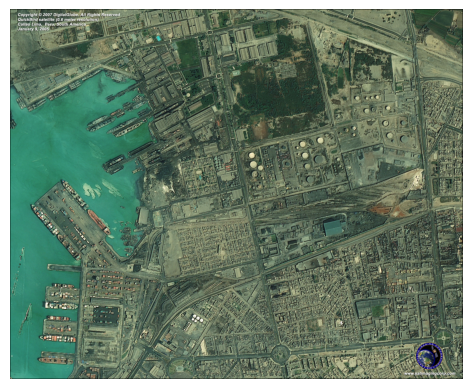

In [69]:
# Chemin vers l'image
imageName = "quickbird-callao-lima-peru.jpg"
image = Image.open(imageName)

# Affichage de l'image
plt.imshow(image)
plt.axis('off')
plt.show()

In [70]:
def cropImage(image, x, y, tx, ty):
    imageNP = np.array(image)
    croppedImageArray = imageNP[y:y + ty, x:x + tx]
    croppedImage = Image.fromarray(croppedImageArray)

    imageName = f"croppedImage_{tx}x{ty}.png"
    croppedImage.save(imageName, "PNG")
    print(f"L'image découpée a été enregistrée sous {imageName}")

    return (croppedImage, imageName)

L'image découpée a été enregistrée sous croppedImage_400x400.png


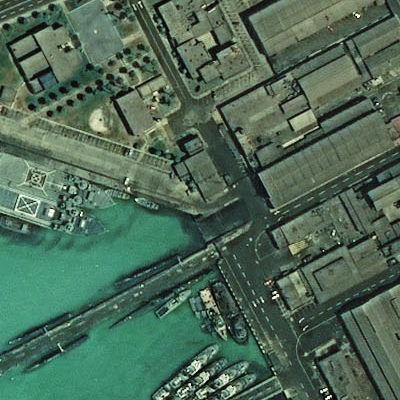

In [71]:
croppedImage, croppedImageName = cropImage(image, 960, 430, 400, 400)
croppedImage

In [72]:
def saveImageformats(image, filename = "imageFormats"):
    formats = ["bmp", "jpeg", "gif", "tiff"]
    savedImages = {}

    for fmt in formats:
        imageName = f"{filename}.{fmt}"
        image.save(imageName, fmt)
        savedImages[fmt] = imageName
        print(f"Image sauvegardée en {fmt} sous {imageName}")

    return savedImages


savedImages = saveImageformats(croppedImage)

Image sauvegardée en bmp sous imageFormats.bmp
Image sauvegardée en jpeg sous imageFormats.jpeg
Image sauvegardée en gif sous imageFormats.gif
Image sauvegardée en tiff sous imageFormats.tiff


Taille de l'image originale : 314.46 KB
Taille de l'image bmp : 468.80 KB
Taille de l'image jpeg : 38.51 KB
Taille de l'image gif : 162.77 KB
Taille de l'image tiff : 468.89 KB


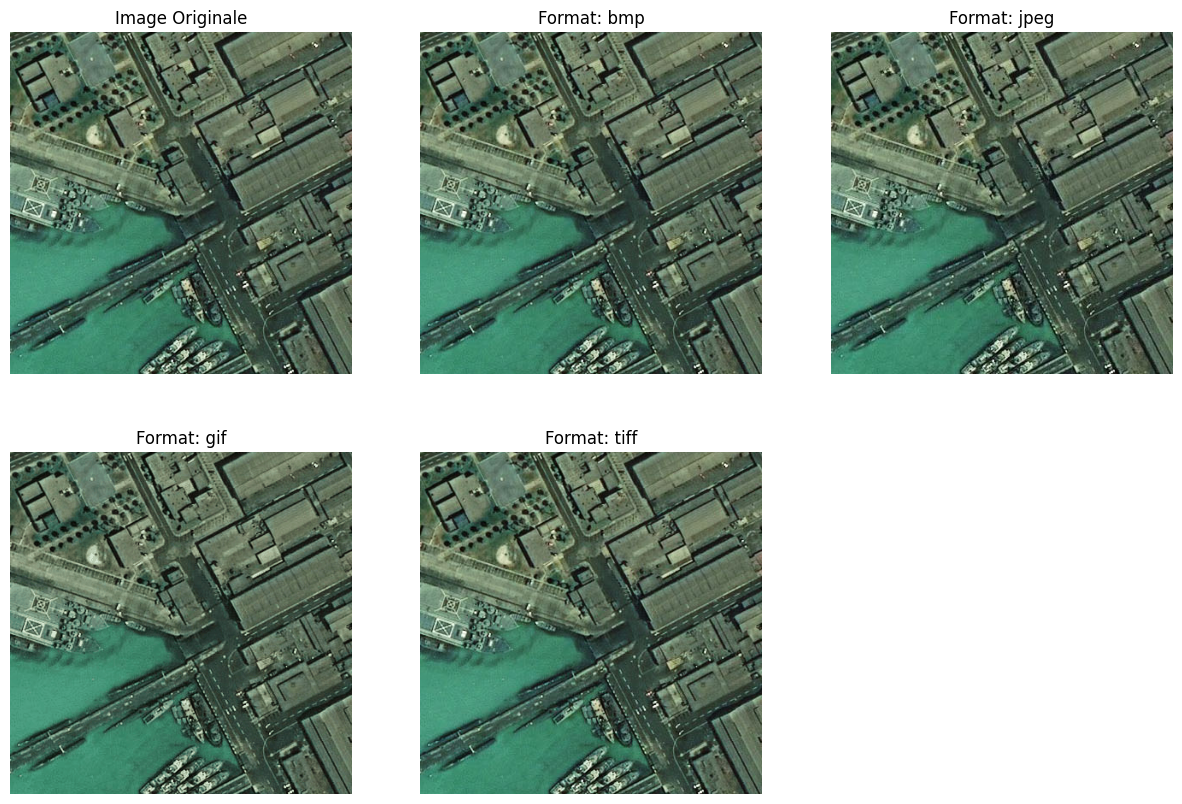

In [73]:
def afficherImages(savedImages, imageOriginalName):
    # Vérifier si le fichier de l'image originale existe
    if not os.path.exists(imageOriginalName):
        print(f"Erreur : le fichier {imageOriginalName} n'existe pas.")
        return
    
    # Afficher l'image originale
    imageOriginal = Image.open(imageOriginalName)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(imageOriginal)
    plt.title("Image Originale")
    plt.axis('off')

    # Calcul et affichage de la taille des fichiers
    originalSize = os.path.getsize(imageOriginalName)
    print(f"Taille de l'image originale : {originalSize / 1024:.2f} KB")

    # Afficher chaque image sauvegardée et afficher la taille
    for i, (fmt, path) in enumerate(savedImages.items(), start=2):
        if not os.path.exists(path):
            print(f"Erreur : le fichier {path} n'existe pas.")
            continue

        compressedImage = Image.open(path)
        plt.subplot(2, 3, i)
        plt.imshow(compressedImage)
        plt.title(f"Format: {fmt}")
        plt.axis('off')
        
        # Taille du fichier
        compressedSize = os.path.getsize(path)
        print(f"Taille de l'image {fmt} : {compressedSize / 1024:.2f} KB")

    plt.show()


afficherImages(savedImages, croppedImageName)


In [74]:
def calculerEQM(image1, image2):
    # Assurez-vous que les deux images ont le même mode et les mêmes dimensions
    if image1.mode != image2.mode:
        image2 = image2.convert("RGB")
    if image1.size != image2.size:
        image2 = image2.resize(image1.size)

    # Convertir les images en tableaux NumPy après conversion et redimension
    arr1 = np.array(image1)
    arr2 = np.array(image2)

    # Vérifier que les dimensions sont identiques
    if arr1.shape != arr2.shape:
        raise ValueError("Les images doivent avoir les mêmes dimensions pour calculer l'EQM.")
    
    # Calculer l'EQM
    eqm = np.mean((arr1 - arr2) ** 2)
    return eqm

# Exemple d'utilisation avec une boucle pour différents formats
for fmt, name in savedImages.items():
    compressedImage = Image.open(name)
    eqm = calculerEQM(croppedImage, compressedImage)
    print(f"EQM entre l'image originale et l'image en {fmt}: {eqm:.2f}")


EQM entre l'image originale et l'image en bmp: 0.00
EQM entre l'image originale et l'image en jpeg: 24.78
EQM entre l'image originale et l'image en gif: 7.68
EQM entre l'image originale et l'image en tiff: 0.00


Taille de l'image originale : 314.46 KB
Taille de l'image equalized : 382.02 KB


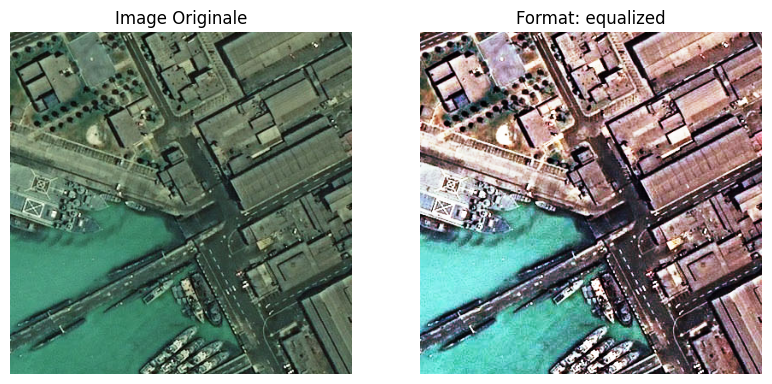

In [75]:
def egalisationHistogramme(image):
    imageNP = np.array(image)
    L = 256
    n = imageNP.shape[0] * imageNP.shape[1]

    equalizedChannels = []
    for i in range(3):
        canal = imageNP[:, :, i]

        histogram, _ = np.histogram(canal.flatten(), bins=L, range=[0, L])
        cumsumHistogram = np.cumsum(histogram)
        cumsumHistogramNormalized = (L - 1) * cumsumHistogram / n

        egalisedCanal = cumsumHistogramNormalized[canal]
        equalizedChannels.append(egalisedCanal.astype(np.uint8))
    
    imageEqualizedArray = np.stack(equalizedChannels, axis=-1)

    imageName = "imageEqualized.png"
    imageEqualized = Image.fromarray(imageEqualizedArray)

    imageEqualized.save(imageName, "png")

    saveImage = {}
    saveImage["equalized"] = imageName
    return (saveImage, imageEqualized)

imageEqualizedName, imageEqualized = egalisationHistogramme(croppedImage)
afficherImages(imageEqualizedName, croppedImageName)

#[15 , 20, 90, 0, 3 ....]

#[15, 35, 125, ....]

In [76]:
eqm = calculerEQM(imageEqualized, croppedImage)
print(f"EQM entre l'image originale et l'image égaliser: {eqm:.2f}")

EQM entre l'image originale et l'image égaliser: 104.64


it can also be used on color images by applying the same method separately to the Red, Green and Blue components of the RGB color values of the image. However, applying the same method on the Red, Green, and Blue components of an RGB image may yield dramatic changes in the image's color balance since the relative distributions of the color channels change as a result of applying the algorithm.
However, if the image is first converted to another color space, Lab color space, or HSL/HSV color space in particular, then the algorithm can be applied to the luminance or value channel without resulting in changes to the hue and saturation of the image.

source : [Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization)

Taille de l'image originale : 314.46 KB
Taille de l'image imageHSV : 368.46 KB


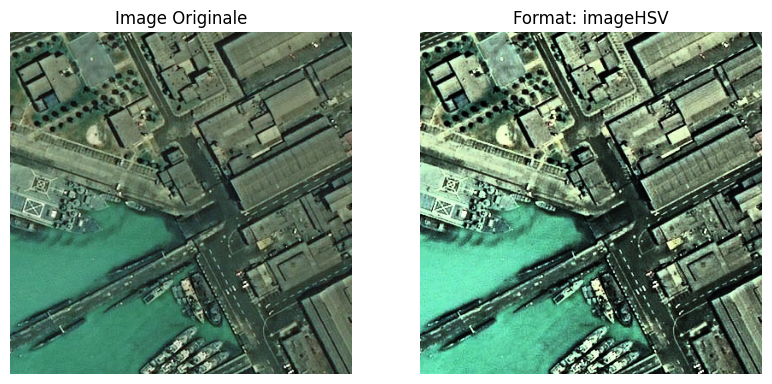

In [77]:
def egalisationHistogrammeHSV(imageName):
    image = cv2.imread(imageName)
    imageHSVArray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    imageHSVArray[:, :, 2] = cv2.equalizeHist(imageHSVArray[:, :, 2])

    imageHSVBGR = cv2.cvtColor(imageHSVArray, cv2.COLOR_HSV2BGR)
    imageHSV = Image.fromarray(cv2.cvtColor(imageHSVBGR, cv2.COLOR_BGR2RGB))

    imageHSVName = "imageHSV.png"
    imageHSV.save(imageHSVName, "png")

    saveImage = {}
    saveImage["imageHSV"] = imageHSVName
    return (saveImage, imageHSV)

imageHSVName, imageHSV = egalisationHistogrammeHSV(croppedImageName)
afficherImages(imageHSVName, croppedImageName)

In [78]:
eqm = calculerEQM(imageHSV, croppedImage)
print(f"EQM entre l'image originale et l'image égaliser: {eqm:.2f}")

EQM entre l'image originale et l'image égaliser: 100.45


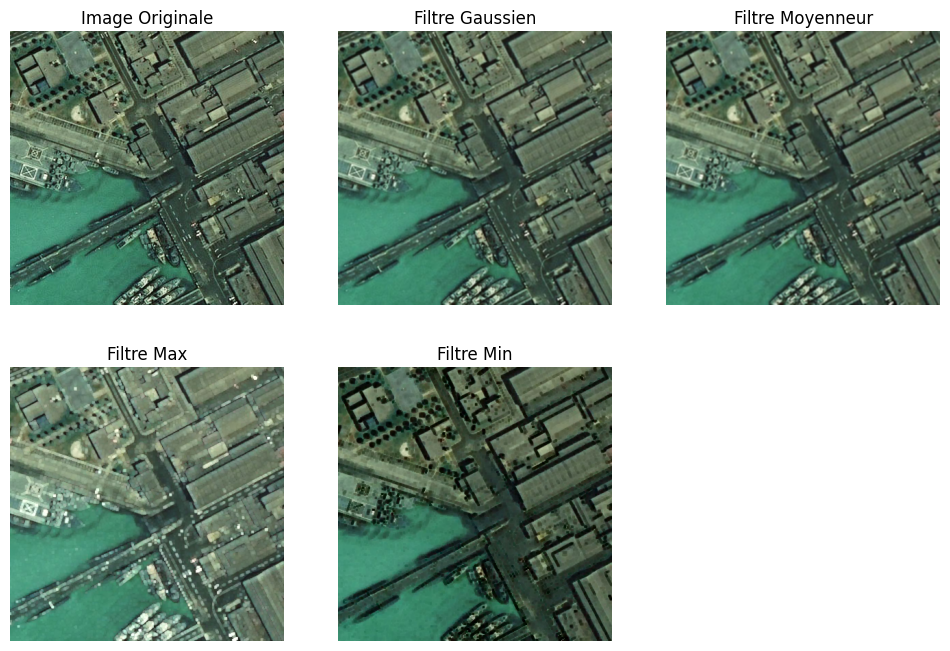

EQM entre l'image originale et l'image filtrée (Gaussien) : 36.17
EQM entre l'image originale et l'image filtrée (Moyenneur) : 44.52
EQM entre l'image originale et l'image filtrée (Max) : 81.36
EQM entre l'image originale et l'image filtrée (Min) : 80.86


In [79]:
def FiltreGaussien(image, iterations=1):
    imageArray = np.array(image)
    for _ in range(iterations):
        imageArray = cv2.GaussianBlur(imageArray, (3, 3), 0)
    return Image.fromarray(imageArray)

def FiltreMoyenneur(image):
    imageArray = np.array(image)
    kernel = np.ones((3, 3), np.float32) / 9
    imageArray = cv2.filter2D(imageArray, -1, kernel)
    return Image.fromarray(imageArray)

def FiltreMax(image):
    imageArray = np.array(image)
    imageArray = cv2.dilate(imageArray, np.ones((3, 3), np.uint8))
    return Image.fromarray(imageArray)

def FiltreMin(image):
    imageArray = np.array(image)
    imageArray = cv2.erode(imageArray, np.ones((3, 3), np.uint8))
    return Image.fromarray(imageArray)


imageGaussienne = FiltreGaussien(croppedImage)
imageMoyenneur = FiltreMoyenneur(croppedImage)
imageMax = FiltreMax(croppedImage)
imageMin = FiltreMin(croppedImage)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(croppedImage, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(imageGaussienne, cmap='gray')
plt.title("Filtre Gaussien")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(imageMoyenneur, cmap='gray')
plt.title("Filtre Moyenneur")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(imageMax, cmap='gray')
plt.title("Filtre Max")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(imageMin, cmap='gray')
plt.title("Filtre Min")
plt.axis('off')

plt.show()

eqmGaussien = calculerEQM(imageGaussienne, croppedImage)
eqmMoyenneur = calculerEQM(imageMoyenneur, croppedImage)
eqmMax = calculerEQM(imageMax, croppedImage)
eqmMin = calculerEQM(imageMin, croppedImage)

print(f"EQM entre l'image originale et l'image filtrée (Gaussien) : {eqmGaussien:.2f}")
print(f"EQM entre l'image originale et l'image filtrée (Moyenneur) : {eqmMoyenneur:.2f}")
print(f"EQM entre l'image originale et l'image filtrée (Max) : {eqmMax:.2f}")
print(f"EQM entre l'image originale et l'image filtrée (Min) : {eqmMin:.2f}")
